# Testing procedure for 1D pendulum

In [1]:
import numpy as np
from numpy import random
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)

## Create training and testing signals

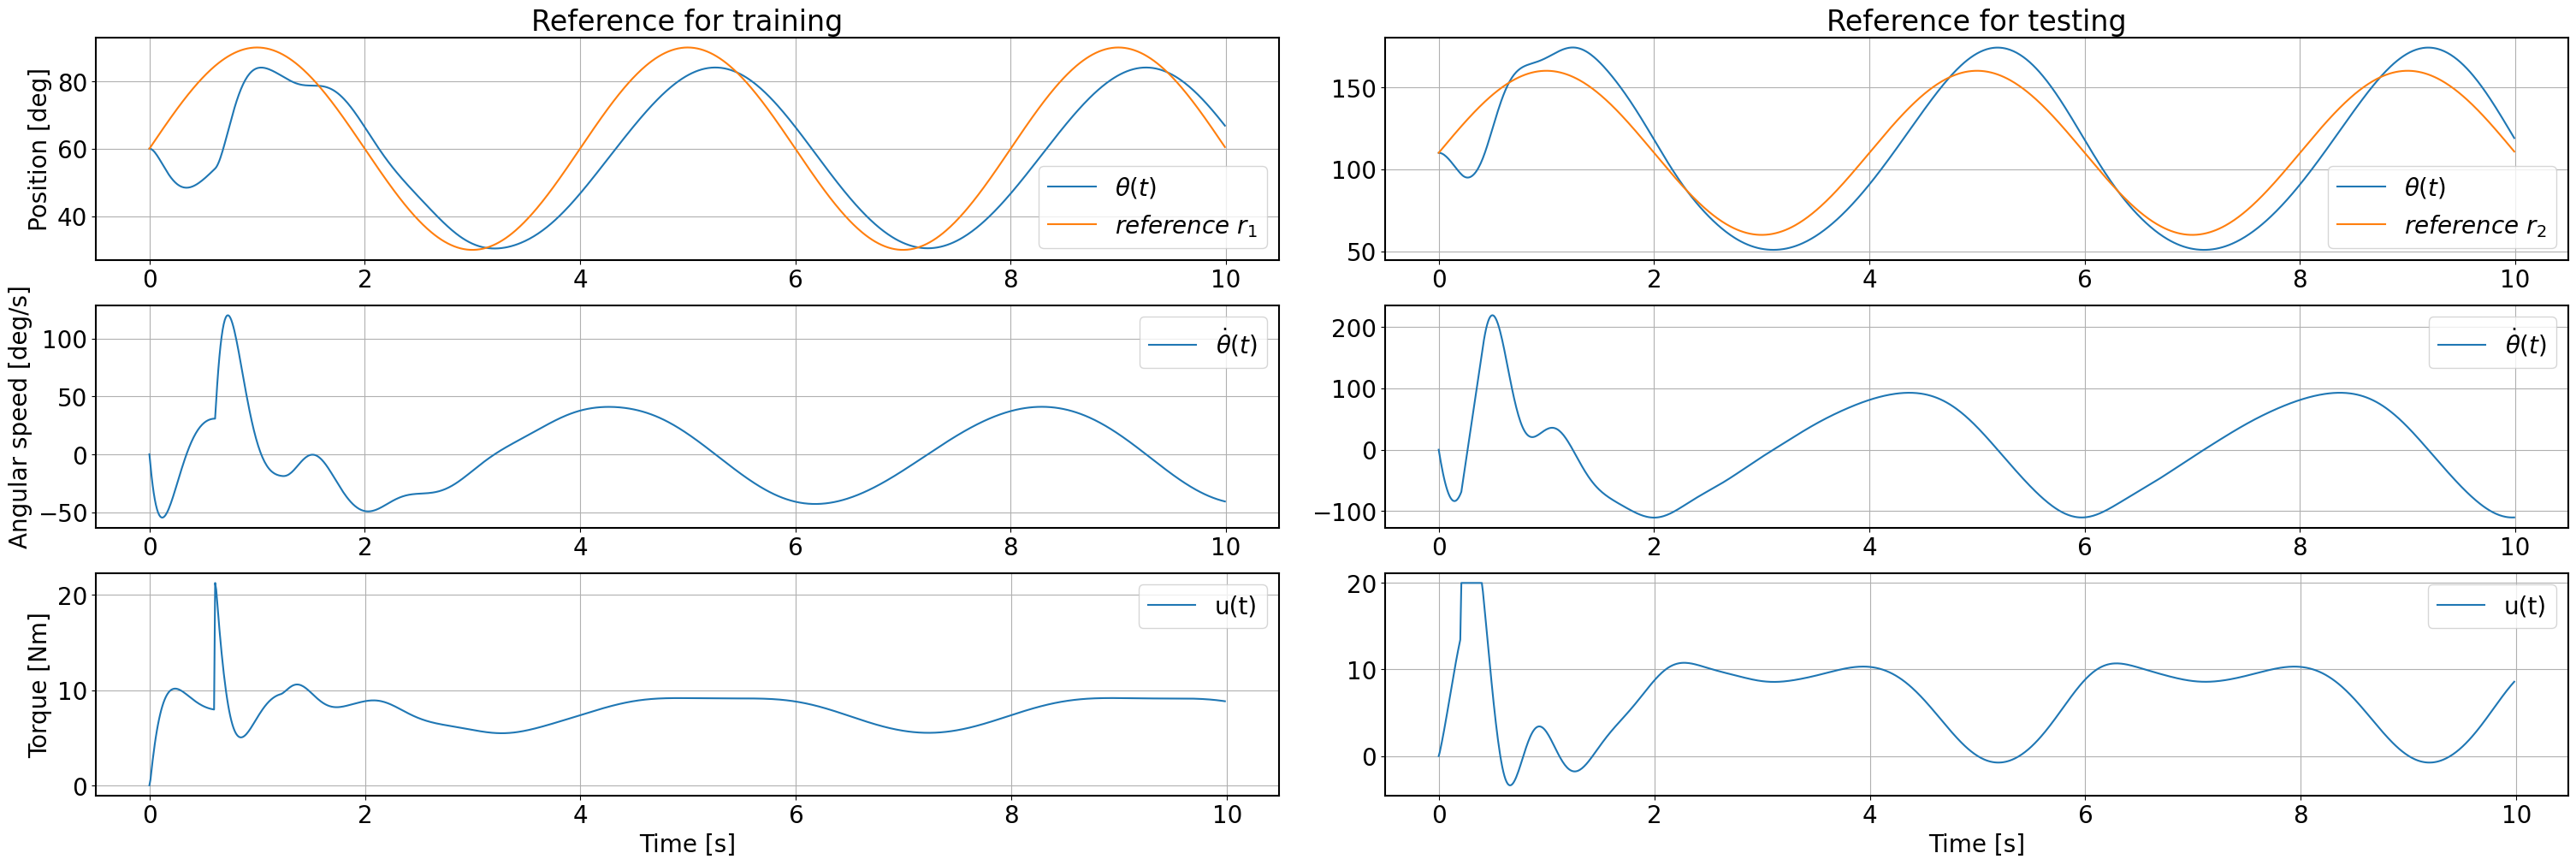

In [83]:
# Pendulum instance
dt = 1e-2
time = np.arange(0,10,dt)
pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(60),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(110),0]), dt=dt)

# Controller design
K, Ki, Kd, t_max = 10, 50, 0, 12

# Reference design
freq = .25
pend1.T_ref, pend2.T_ref = 1/freq/pend1.dt, 1/freq/pend2.dt
amplitude1, amplitude2 = 30, 50 # deg
pend1.ref = sineReference(pend1.N, pend1.dt, pend1.T_ref, amplitude1, 60)
# pend1.ref = sineReference(pend1.N, pend1.dt, [], [], offset=60, varying=True, freq_vector=[.4], amp_vector=[30])
# pend1.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(0),deg2rad(90)], np.int(pend1.T_ref/10), 0)
pend2.ref = sineReference(pend2.N, pend1.dt, pend2.T_ref, amplitude2, 110)
# pend2.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(50),deg2rad(130)], np.int(pend1.T_ref/10), 0)

# Simulation

integral = 0
for i in range(pend1.N-1):
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], 20, 5, 10, pend1.dt, 60, limit=30, integral=integral)[0]
#     pend1.U[i] = U[0]
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 25, 1, 15, pend2.dt, 20, limit=20)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(3, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,0].plot(pend1.T, rad2deg(np.array(pend1.ref)), label=r"$reference \ r_1$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend2.T, rad2deg(np.array(pend2.ref)), label=r"$reference \ r_2$")
ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()
ax[0,0].set_title('Reference for training'), ax[0,1].set_title('Reference for testing')

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend2.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_ylabel('Angular speed [deg/s]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

ax[2,0].plot(pend1.T[:pend1.N-1], pend1.U, label='u(t)')
ax[2,1].plot(pend2.T[:pend1.N-1], pend2.U, label='u(t)')
ax[2,0].set_xlabel('Time [s]'), ax[2,0].set_ylabel('Torque [Nm]'), ax[2,1].set_xlabel('Time [s]')
ax[2,0].grid(), ax[2,1].grid()
ax[2,0].legend(), ax[2,1].legend()

fig.savefig('Pend_id_sine.svg',format='svg',dpi=600)

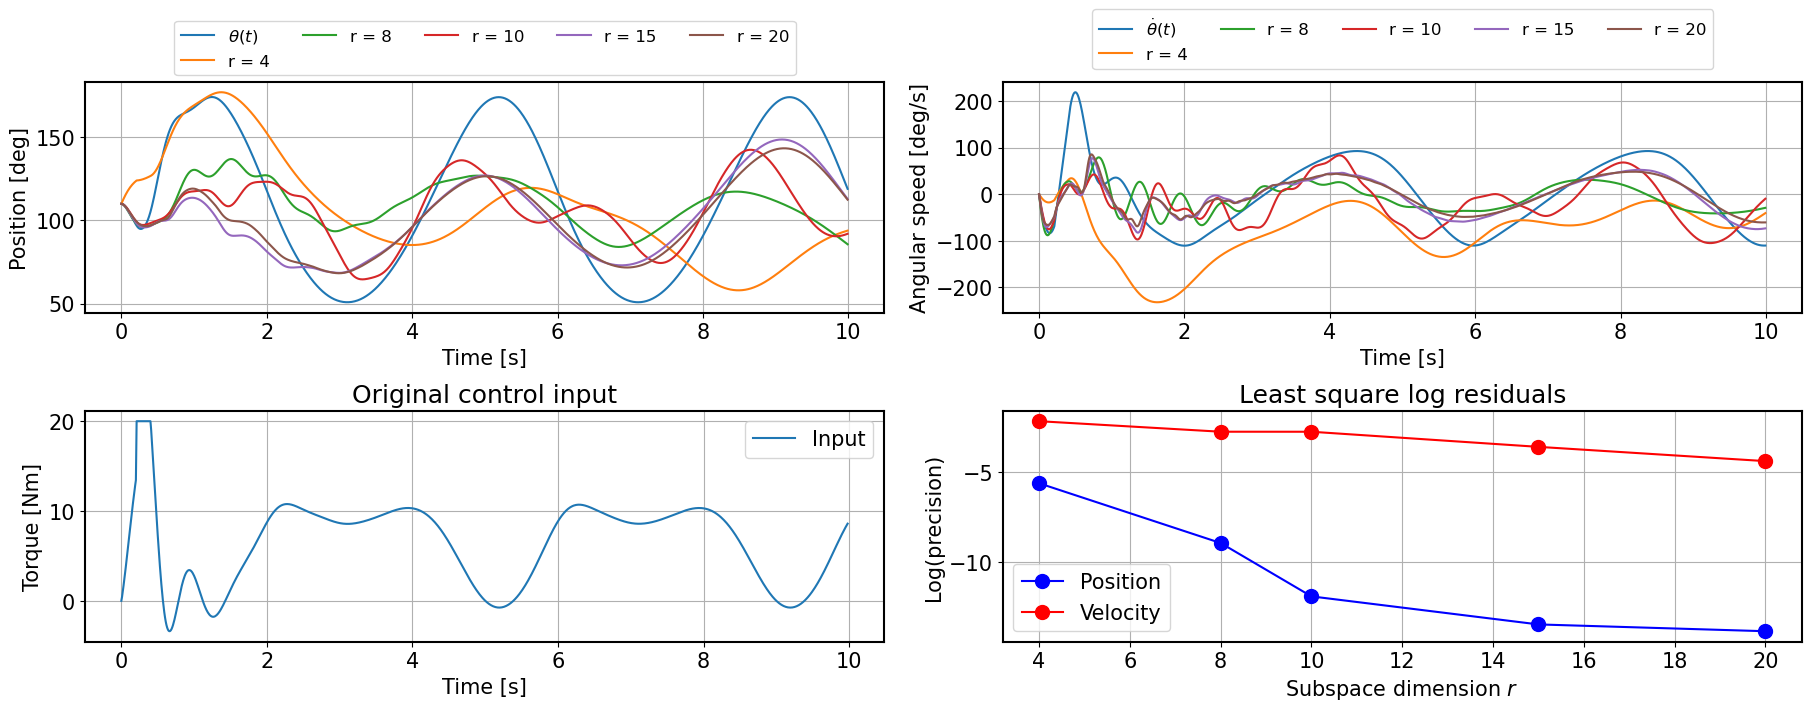

In [84]:
# In the following, pend1 --> training of A & B
#                   pend2 --> testing (trajectory simulation)

pend = pend1
horizon = np.int(len(pend.T)*.6)
model1 = HAVOK(pend.X, pend1.U)
X0 = [deg2rad(60),0]

nb_delay = [4,8,10,15,20]
# nb_delay = [5]
nb_plots = len(nb_delay)
res = np.empty(shape=[2,nb_plots])

plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

pend = pend2

ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()

ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg]')
ax[0,1].grid()

ax[1,0].plot(pend.T[:len(pend.T)-1], pend.U, label='Input')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid(), ax[1,0].legend(), ax[1,0].set_title('Original control input')

for i in range(nb_plots):
    tau = nb_delay[i]
    model1.HANKEL(horizon)
    model1.SVD(tau)
    model1.LS()
    model1.Simulate(pend.X0, U_testing=pend.U)
    
    
    ax[0,0].plot(pend.T[:len(pend.T)], rad2deg(model1.X_traj[0,:]), label='r = '+str(tau))
    ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
    ax[0,0].grid()
    ax[0,0].legend(bbox_to_anchor=(.9, 1.3),ncol=nb_plots,fontsize=12)

    ax[0,1].plot(pend.T[:len(pend.T)], rad2deg(model1.X_traj[1,:]), label='r = '+str(tau))
    ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
    ax[0,1].grid()
    ax[0,1].legend(bbox_to_anchor=(.9, 1.35),ncol=nb_plots,fontsize=12)
    
    res[:,i] = model1.residuals
    
ax[1,1].plot(nb_delay, np.log(res[0,:]),'-o', markersize=10, color='b', label='Position')
ax[1,1].plot(nb_delay, np.log(res[1,:]),'-o', markersize=10, color='r', label='Velocity')
ax[1,1].set_xlabel(r'Subspace dimension $r$'), ax[1,1].set_ylabel('Log(precision)'), ax[1,1].legend()
ax[1,1].grid(), ax[1,1].set_title('Least square log residuals')
ax[0,0].grid(), ax[0,1].grid()

fig.savefig('Images/Pend_DMD_sine.svg',format='svg',dpi=600)

## LQR control of learned dynamics
### LQR rollout

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(898.3763226465504, 0.5, 'Subspace coordinate $r$'))

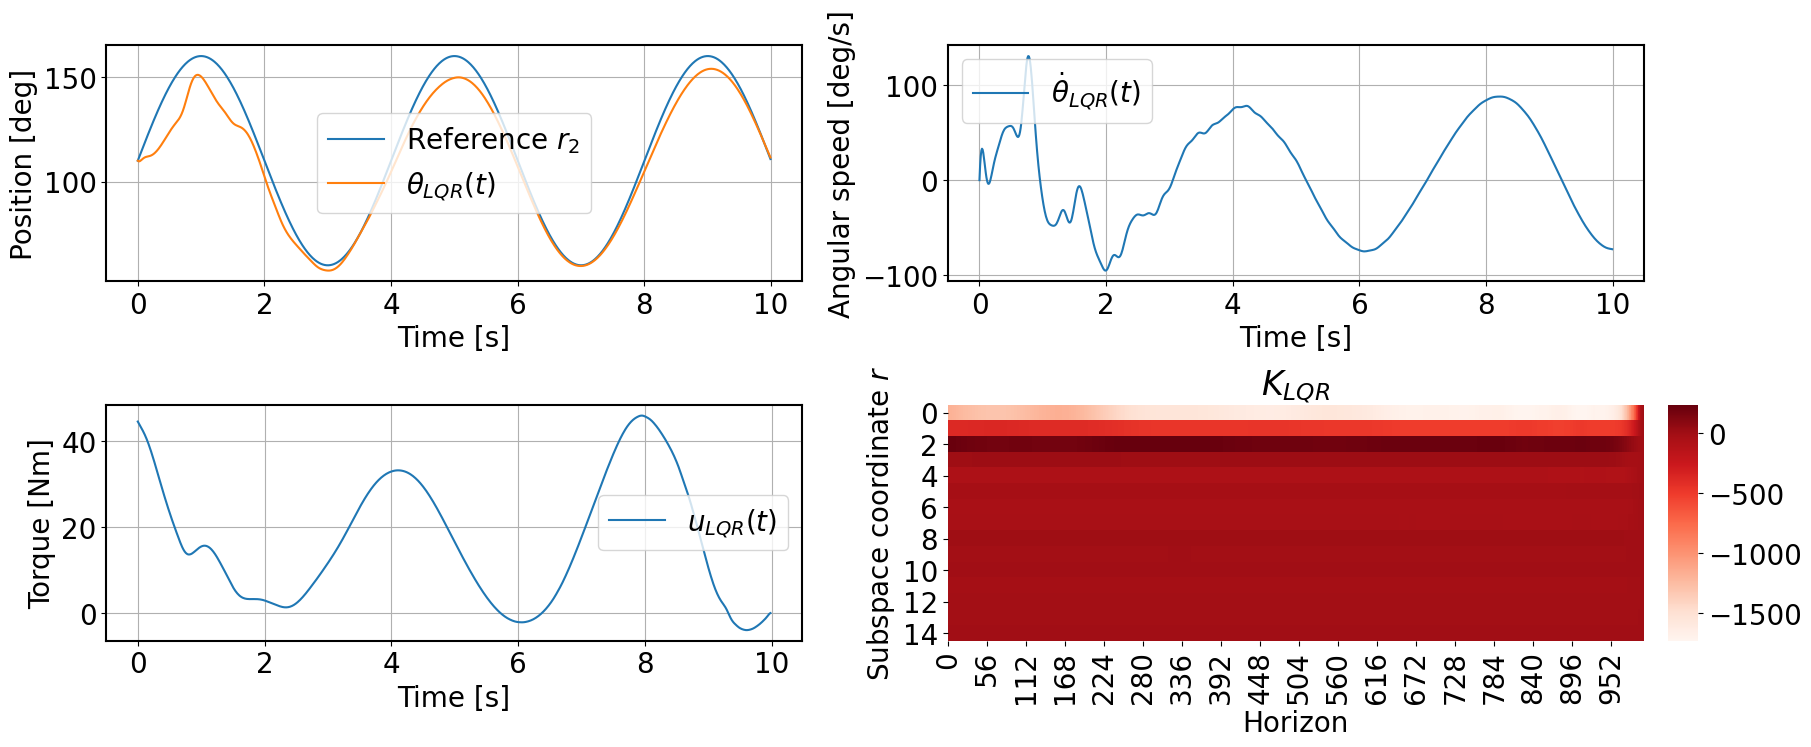

In [85]:
tau = 15
# Training
pend=pend1 
model1 = HAVOK(pend.X, pend.U)
model1.HANKEL(horizon)
model1.SVD(tau)
model1.LS()
# Testing
pend=pend2
model1.Simulate(pend.X0, U_testing=pend.U)
model1.ConstructLQR(x_std=1e6, u_std=2., dt=pend.dt, ref=pend.ref)
model1.LQR_simulate(pend.X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref)), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], us[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

### LQR planning for true dynamics

LQR cost :  3185496429.908648


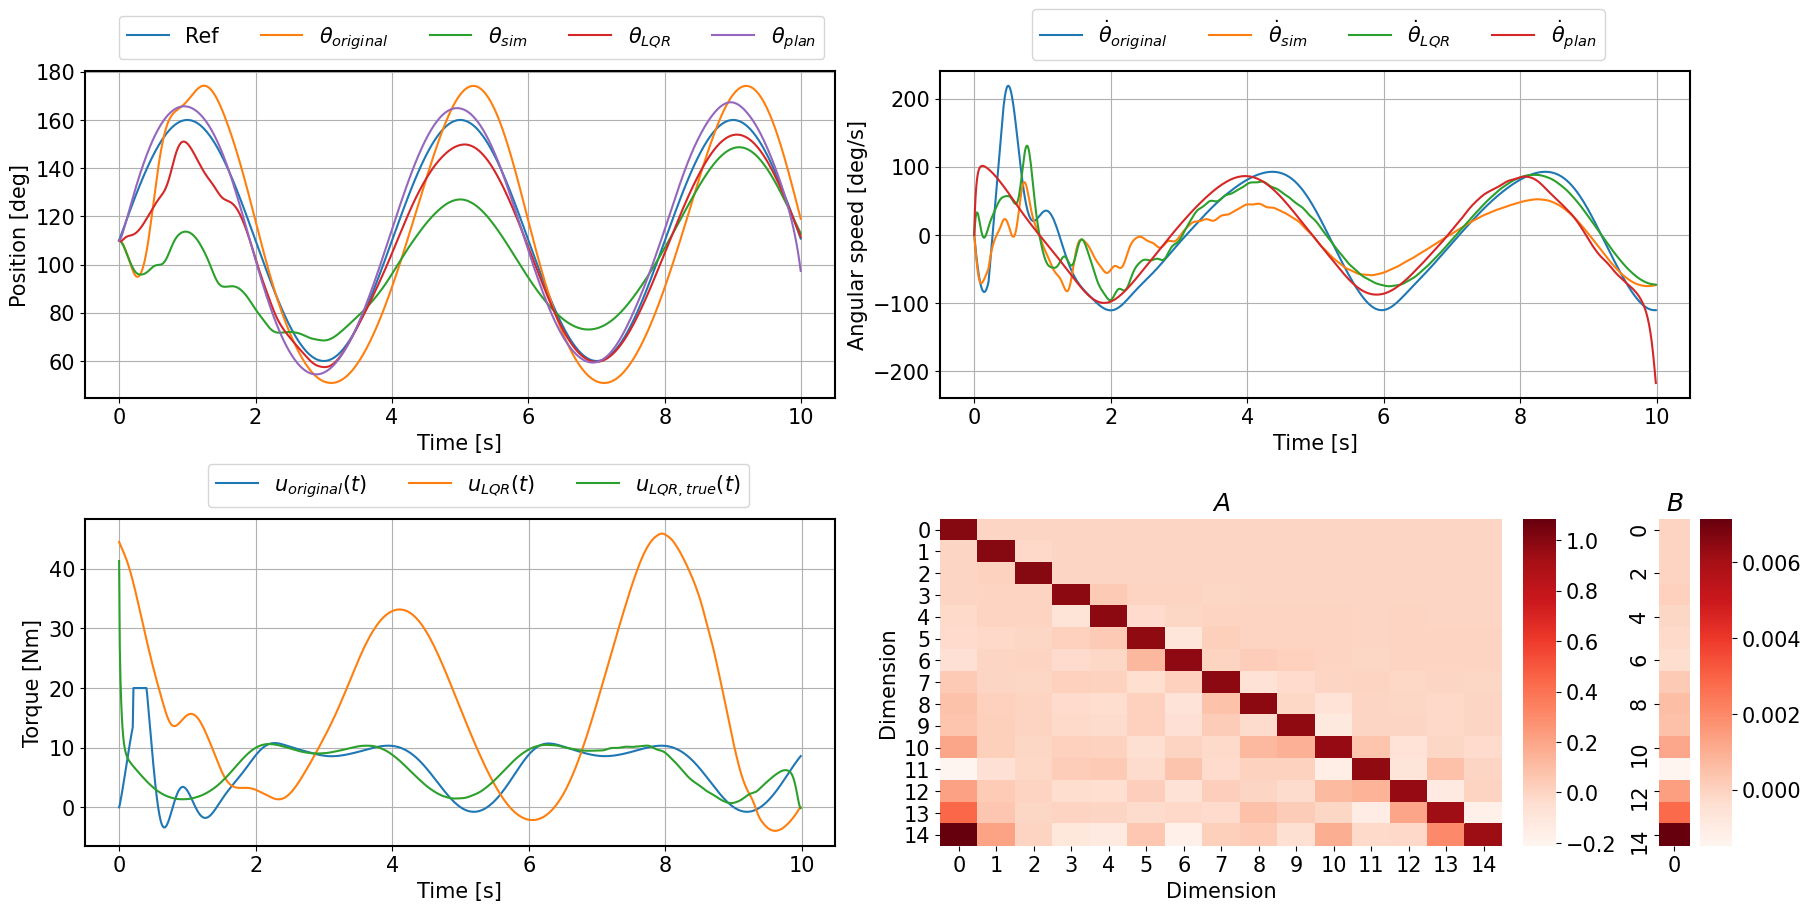

In [92]:
pend = pend2
X0 = pend.X0
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = model1.LQR.get_command(Yc[:,i],i)
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
print('LQR cost : ',model1.LQR_cost(Xc, Uc, pend.ref))
    
# Plot
plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(18,9))

gs = fig.add_gridspec(8, 8)

ax00 = fig.add_subplot(gs[0:4,0:4])
ax01 = fig.add_subplot(gs[0:4,4:8])
ax10 = fig.add_subplot(gs[4:8,0:4])
ax11_0 = fig.add_subplot(gs[4:8,4:7])
ax11_1 = fig.add_subplot(gs[4:8,7:8])

ax00.plot(pend.T, rad2deg(np.array(pend.ref)), label='Ref')
ax00.plot(pend.T, rad2deg(pend.X[0,:]), label=r'$\theta_{original}$')
ax00.plot(pend.T, rad2deg(model1.X_traj[0,:]), label=r"$\theta_{sim}$")
ax00.plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r'$\theta_{LQR}$')
ax00.plot(pend.T, rad2deg(Xc[0,:]), label=r"$\theta_{plan}$")
ax00.set_xlabel('Time [s]'), ax00.set_ylabel('Position [deg]')
ax00.grid()
ax00.legend(bbox_to_anchor=(1, 1.2),ncol=5)

ax01.plot(pend.T, rad2deg(pend.X[1,:]), label=r'$\dot{\theta}_{original}$')
ax01.plot(pend.T, rad2deg(model1.X_traj[1,:]), label=r"$\dot{\theta}_{sim}$")
ax01.plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR}$")
ax01.plot(pend.T, rad2deg(Xc[1,:]), label=r"$\dot{\theta}_{plan}$")
ax01.set_xlabel('Time [s]'), ax01.set_ylabel('Angular speed [deg/s]')
ax01.grid()
ax01.legend(bbox_to_anchor=(.9, 1.22),ncol=4)

ax10.plot(pend.T[:model1.N-1], pend.U, label='$u_{original}(t)$')
ax10.plot(pend.T[:model1.N-1], us[0,:,0], label='$u_{LQR}(t)$')
ax10.plot(pend.T[:model1.N-1], Uc, label='$u_{LQR,true}(t)$')
ax10.set_xlabel('Time [s]'), ax10.set_ylabel('Torque [Nm]')
ax10.grid()
ax10.legend(bbox_to_anchor=(.9, 1.2),ncol=3)

ax11_0.set_title('$A$')
figA = snb.heatmap(model1.A,cmap='Reds',ax=ax11_0)
ax11_0.set_ylabel('Dimension'), ax11_0.set_xlabel('Dimension')

ax11_1.set_title('$B$')
figA = snb.heatmap(model1.B,cmap='Reds')

fig.savefig('Images/Pend_HAVOK_trajectories.svg',format='svg',dpi=800)